In [1]:
import numpy as np 
import pandas as pd 
import os
import re

In [2]:
import keras

Using TensorFlow backend.
/Users/yuyunzhi/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/yuyunzhi/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/yuyunzhi/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/yuyunzhi/opt/anaconda3/lib/p

In [3]:
import tensorflow

In [4]:
import tensorflow as tf

In [5]:
from tensorflow import keras

In [6]:
from bs4 import BeautifulSoup 

import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
from __future__ import absolute_import, division, print_function, unicode_literals
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
sns.set(rc={'figure.figsize' : (12, 6)})
sns.set_style("darkgrid", {'axes.grid' : True})
import skimage

## Import Data

In [8]:
data = pd.read_csv('rotten_tomatoes_reviews.csv')
data.head()

,Freshness,Review
0,1,"Manakamana doesn't answer any questions, yet ..."
1,1,Wilfully offensive and powered by a chest-thu...
2,0,It would be difficult to imagine material mor...
3,0,Despite the gusto its star brings to the role...
4,0,If there was a good idea at the core of this ...


In [10]:
data['Review']

0          Manakamana doesn't answer any questions, yet ...
1          Wilfully offensive and powered by a chest-thu...
2          It would be difficult to imagine material mor...
3          Despite the gusto its star brings to the role...
4          If there was a good idea at the core of this ...
                                ...                        
479995     Zemeckis seems unable to admit that the motio...
479996     Movies like The Kids Are All Right -- beautif...
479997     Film-savvy audiences soon will catch onto Win...
479998                          An odd yet enjoyable film. 
479999     No other animation studio, even our beloved P...
Name: Review, Length: 480000, dtype: object

In [11]:
category_data = pd.read_csv('train.tsv', sep = '\t')

In [12]:
category_data

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [13]:
category_data['Phrase'][0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [14]:
category_data['Phrase'][1]

'A series of escapades demonstrating the adage that what is good for the goose'

In [15]:
data = data.rename(columns={"Freshness": "sentiment", "Review": "review"})

In [16]:
data

,sentiment,review
0,1,"Manakamana doesn't answer any questions, yet ..."
1,1,Wilfully offensive and powered by a chest-thu...
2,0,It would be difficult to imagine material mor...
3,0,Despite the gusto its star brings to the role...
4,0,If there was a good idea at the core of this ...
...,...,...
479995,0,Zemeckis seems unable to admit that the motio...
479996,1,Movies like The Kids Are All Right -- beautif...
479997,0,Film-savvy audiences soon will catch onto Win...
479998,1,An odd yet enjoyable film.


In [17]:
data.shape

(480000, 2)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480000 entries, 0 to 479999
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  480000 non-null  int64 
 1   review     480000 non-null  object
dtypes: int64(1), object(1)
memory usage: 7.3+ MB


In [19]:
# Number of poitive and negative reviews
data.sentiment.value_counts()

1    240000
0    240000
Name: sentiment, dtype: int64

In [20]:
# 0 is a negative review, and 1 is a positive review.
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
data['sentiment'] = label_encoder.fit_transform(data['sentiment'])
data.head()

,sentiment,review
0,1,"Manakamana doesn't answer any questions, yet ..."
1,1,Wilfully offensive and powered by a chest-thu...
2,0,It would be difficult to imagine material mor...
3,0,Despite the gusto its star brings to the role...
4,0,If there was a good idea at the core of this ...


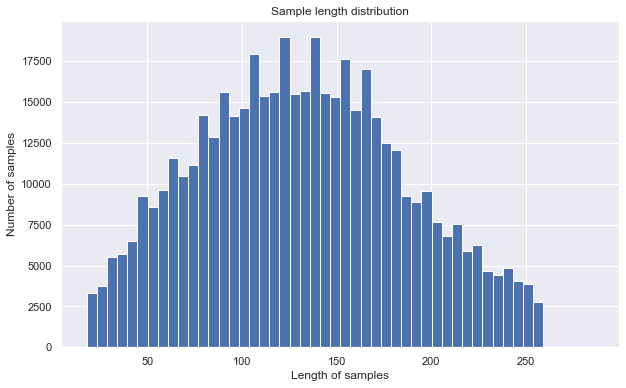

In [21]:
# Now, let's see the average number of words per sample
plt.figure(figsize=(10, 6))
plt.hist([len(sample) for sample in list(data['review'])], 50)
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

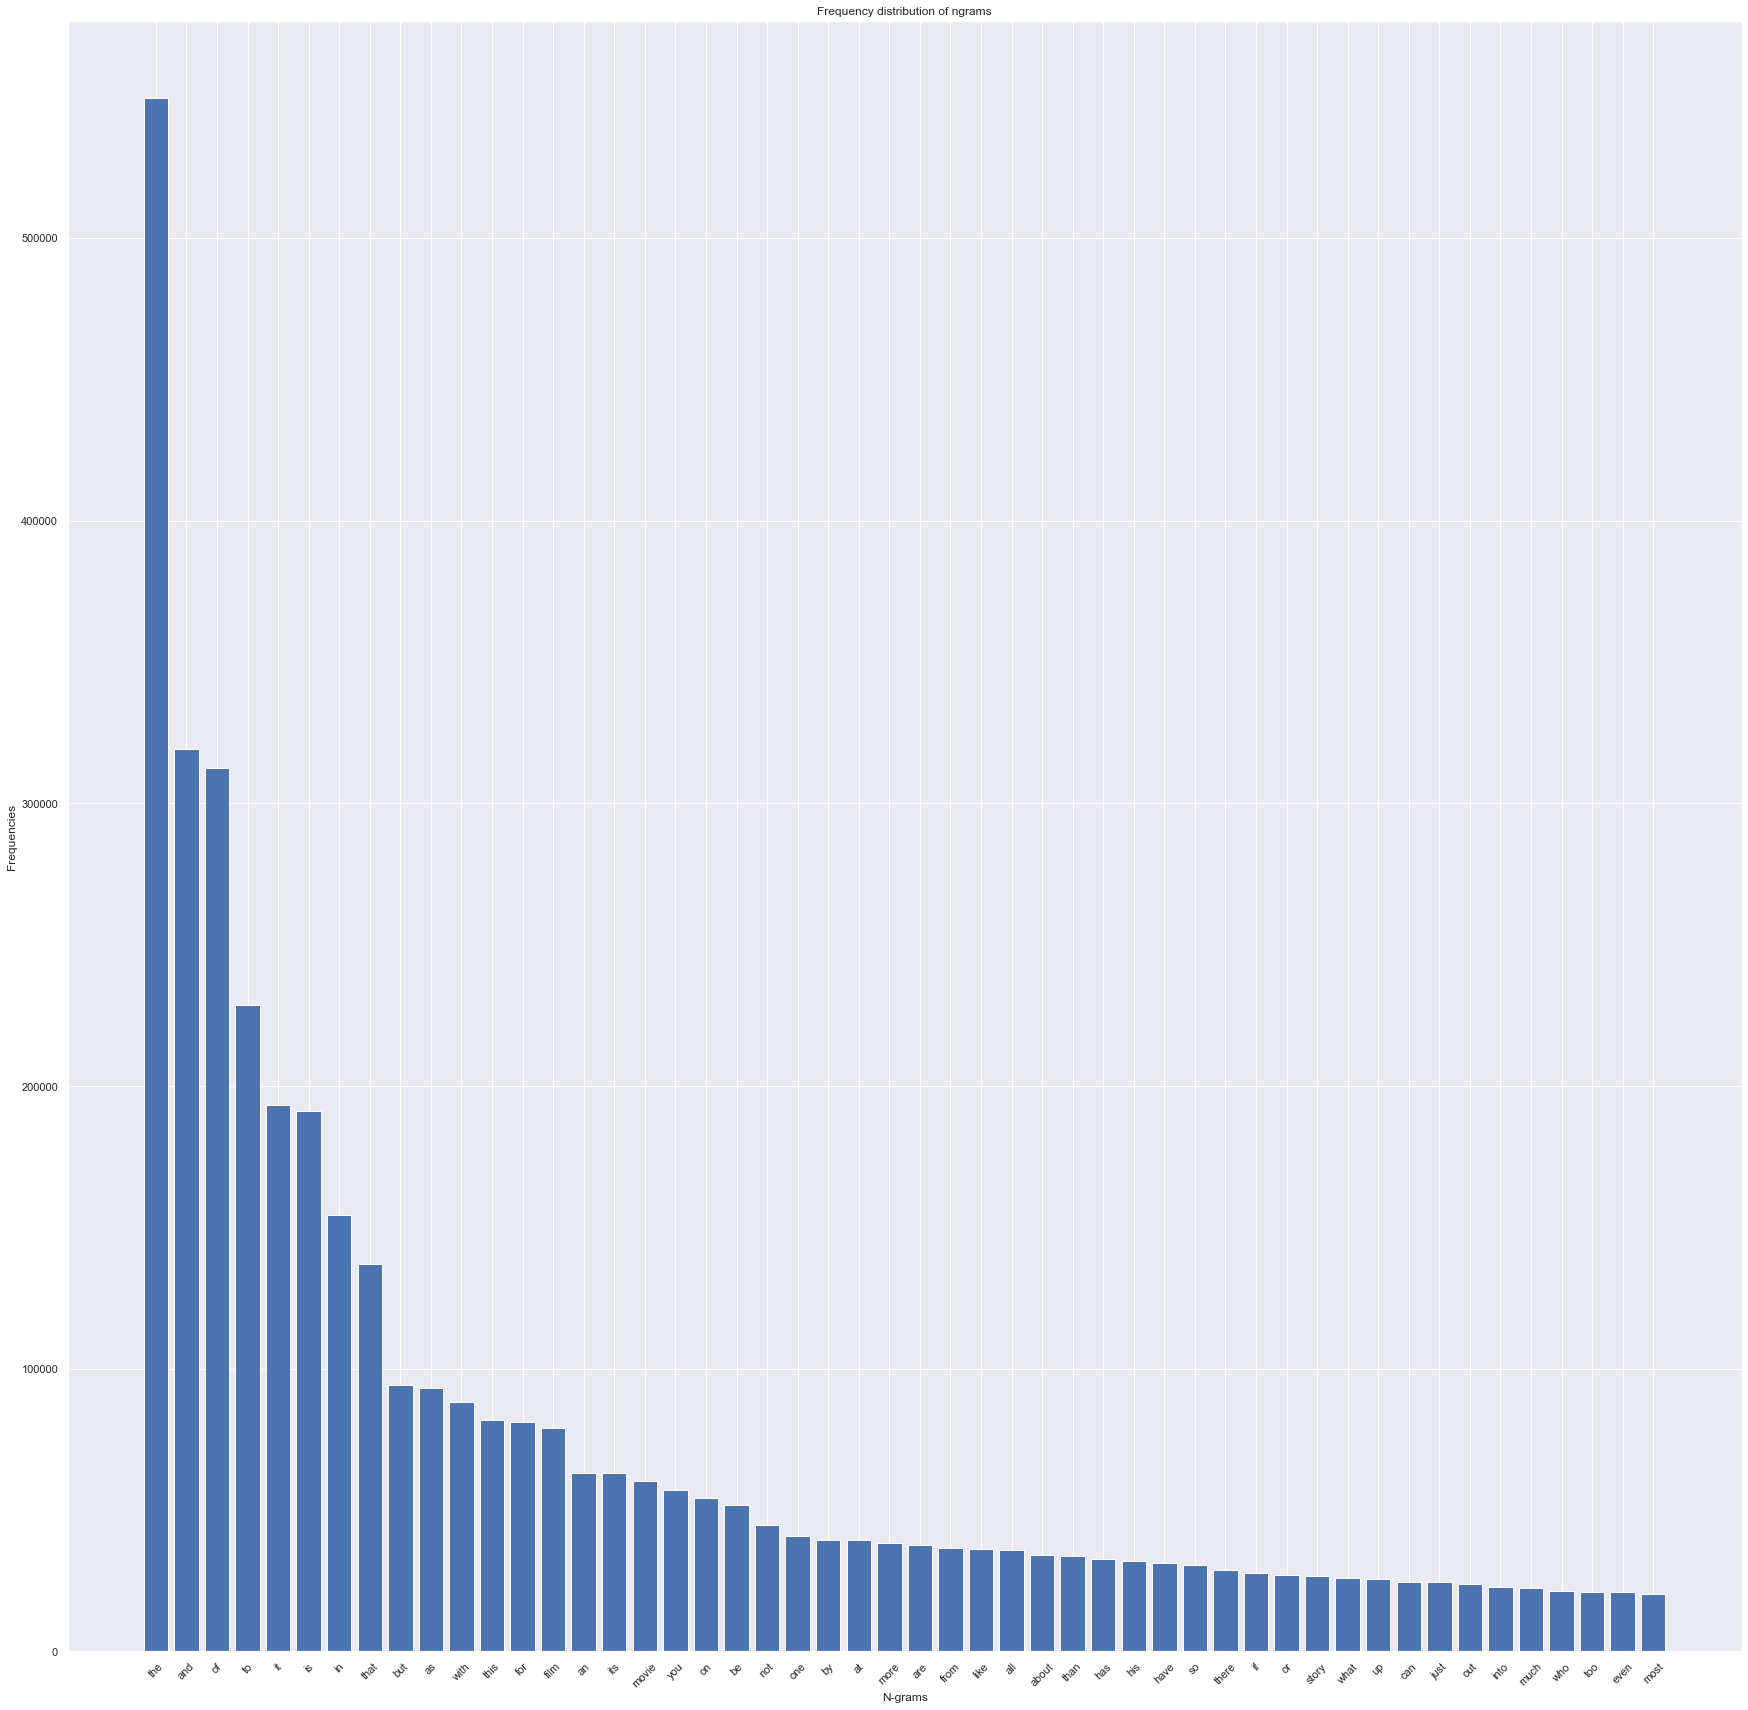

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
# So, we get such structure:
#        | word1  | word2  |  word3 | word4
# text1  |   1    |    1   |   1    |   0
# text2  |   0    |    1   |   1    |   0
# text3  |   2    |    1   |   0    |   0
# text4  |   0    |    0   |   0    |   1
vect_texts = vectorizer.fit_transform(list(data['review']))
# ['word1', 'word2', 'word3', 'word4']
all_ngrams = vectorizer.get_feature_names()
num_ngrams = min(50, len(all_ngrams))
all_counts = vect_texts.sum(axis=0).tolist()[0]

all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])
ngrams = all_ngrams[:num_ngrams]
counts = all_counts[:num_ngrams]

idx = np.arange(num_ngrams)

# Let's now plot a frequency distribution plot of the most seen words in the corpus.
plt.figure(figsize=(30, 30))
plt.bar(idx, counts, width=0.8)
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
NGRAM_RANGE = (1, 2)
TOP_K = 20000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2

def ngram_vectorize(texts, labels):
    kwargs = {
        'ngram_range' : NGRAM_RANGE,
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        'decode_error' : 'replace',
        'analyzer' : TOKEN_MODE,
        'min_df' : MIN_DOC_FREQ,
    }
    # Learn Vocab from train texts and vectorize train and val sets
    tfidf_vectorizer = TfidfVectorizer(**kwargs)
    transformed_texts = tfidf_vectorizer.fit_transform(texts)
    
    # Select best k features, with feature importance measured by f_classif
    # Set k as 20000 or (if number of ngrams is less) number of ngrams   
    selector = SelectKBest(f_classif, k=min(TOP_K, transformed_texts.shape[1]))
    selector.fit(transformed_texts, labels)
    transformed_texts = selector.transform(transformed_texts).astype('float32')
    return transformed_texts
# Vectorize the data
vect_data = ngram_vectorize(data['review'], data['sentiment'])

In [24]:
vect_data.shape

(480000, 20000)

In [25]:
tfidf = TfidfVectorizer()
tr_texts = tfidf.fit_transform(data['review'])
tr_texts.shape

(480000, 85378)

### Split data

In [26]:
from sklearn.model_selection import train_test_split

# Split data to target (y) and features (X)
X = vect_data.toarray()
y = (np.array(data['sentiment']))

# Here we split data to training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
print("Train dataset shape: {0}, \nTest dataset shape: {1}".format(X_train.shape, X_test.shape))

Train dataset shape: (384000, 20000), 
Test dataset shape: (96000, 20000)


In [27]:
y_train.shape

(384000,)

In [28]:
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

In [29]:
# First, let's create a function that returns the appropriate number of units and the activation for the last layer.
def get_last_layer_units_and_activation(num_classes):
    if num_classes == 2:
        activation = 'sigmoid' #binary classification
        units = 1
    else:
        activation = 'softmax' #positive, medium, negative; [1, 2, 3, 4, 5]
        units = num_classes
    return units, activation

In [30]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
DROPOUT_RATE = 0.2
UNITS = 64
NUM_CLASSES = 2
LAYERS = 2
input_shape = X_train.shape[1:]

op_units, op_activation = get_last_layer_units_and_activation(NUM_CLASSES)

model = keras.Sequential()
# Applies Dropout to the input
model.add(Dropout(rate=DROPOUT_RATE, input_shape=input_shape))
for _ in range(LAYERS-1):
    model.add(Dense(units=UNITS, activation='relu'))
    model.add(Dropout(rate=DROPOUT_RATE))
    
model.add(Dense(units=op_units, activation=op_activation))
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1280064   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [31]:
LEARNING_RATE = 1e-3

# Compile model with parameters
if NUM_CLASSES == 2:
    loss = 'binary_crossentropy'
else:
    loss = 'sparse_categorical_crossentropy'
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

## Train the model

In [32]:
EPOCHS = 5
BATCH_SIZE = 128

# Create callback for early stopping on validation loss. If the loss does
# not decrease on two consecutive tries, stop training
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]

# Train and validate model
# To start training, call the model.fit method—the model is "fit" to the training data.
# Note that fit() will return a History object which we can use to plot training vs. validation accuracy and loss.
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)

Train on 384000 samples, validate on 96000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
384000/384000 [==============================] - 210s 546us/sample - loss: 0.4325 - acc: 0.8017 - val_loss: 0.3646 - val_acc: 0.8389
Epoch 2/5
384000/384000 [==============================] - 196s 511us/sample - loss: 0.3749 - acc: 0.8288 - val_loss: 0.3516 - val_acc: 0.8441
Epoch 3/5
384000/384000 [==============================] - 200s 521us/sample - loss: 0.3584 - acc: 0.8367 - val_loss: 0.3481 - val_acc: 0.8474
Epoch 4/5
384000/384000 [==============================] - 202s 527us/sample - loss: 0.3483 - acc: 0.8431 - val_loss: 0.3433 - val_acc: 0.8517
Epoch 5/5
384000/384000 [==============================] - 175s 455us/sample - loss: 0.3375 - acc: 0.8501 - val_loss: 0.3395 - val_acc: 0.8551


## Evaluate the model

In [33]:
# Next, compare how the model performs on the test dataset:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

96000/96000 [==============================] - 9s 89us/sample - loss: 0.3395 - acc: 0.8551
Test loss: 0.33952900210767983
Test accuracy: 0.8551458


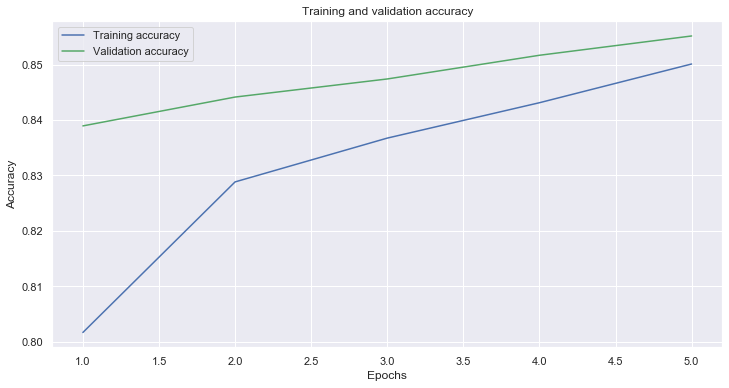

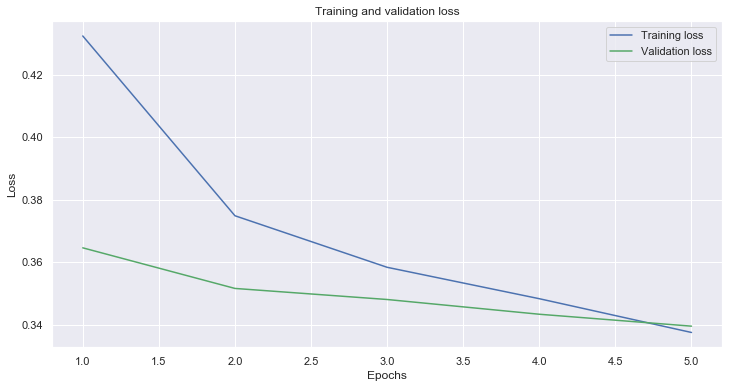

In [34]:
# Let's plot training and validation accuracy as well as loss.
def plot_history(history):
    accuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1,len(accuracy) + 1)
    
    # Plot accuracy  
    plt.figure(1)
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.figure(2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history)

In [42]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score

In [39]:
pred = model.predict(X_test)

In [46]:
pred = [0 if ele < 0.5 else 1 for ele in pred]

In [48]:
cm = confusion_matrix(y_test,pred)
cm

array([[42252,  5820],
       [ 8086, 39842]])

In [49]:
print(classification_report(y_test, pred, target_names = ['Bad Reviews','Good Reviews']))

              precision    recall  f1-score   support

 Bad Reviews       0.84      0.88      0.86     48072
Good Reviews       0.87      0.83      0.85     47928

    accuracy                           0.86     96000
   macro avg       0.86      0.86      0.86     96000
weighted avg       0.86      0.86      0.86     96000



Text(66.5, 0.5, 'Actual')

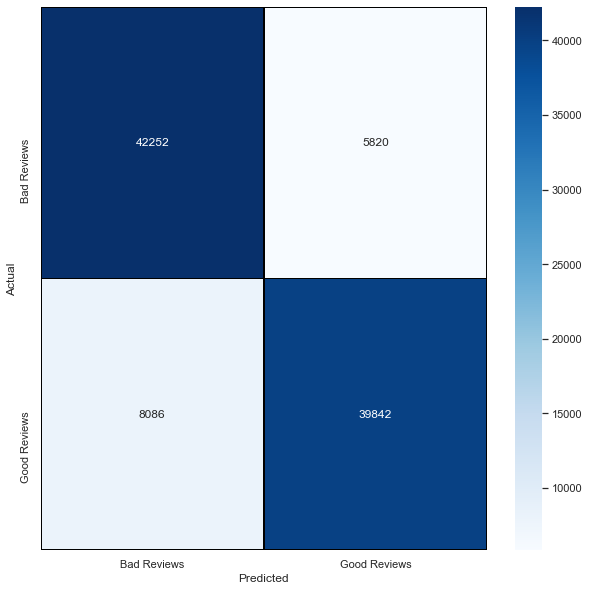

In [50]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Bad Reviews','Good Reviews'] , yticklabels = ['Bad Reviews','Good Reviews'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [52]:
X_train.shape

(384000, 20000)

In [53]:
X_test.shape

(96000, 20000)